Method 1 - Relabeling the data:

Initial Approval Rates by Gender:
Loan_Status         N         Y
Gender                         
Female       0.302198  0.697802
Male         0.267097  0.732903



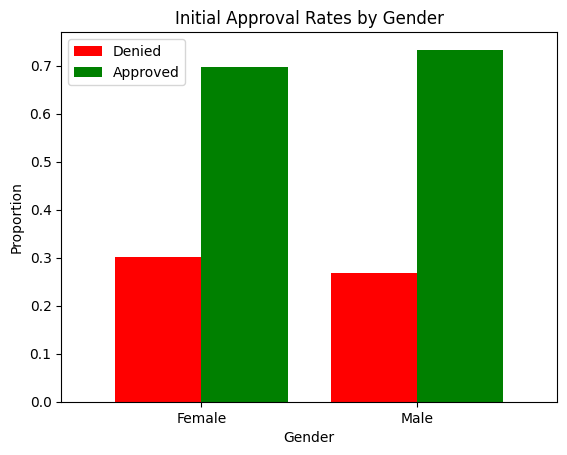

Approval Rates by Gender After Massaging:
Loan_Status         N         Y
Gender                         
Female       0.291209  0.708791
Male         0.267097  0.732903



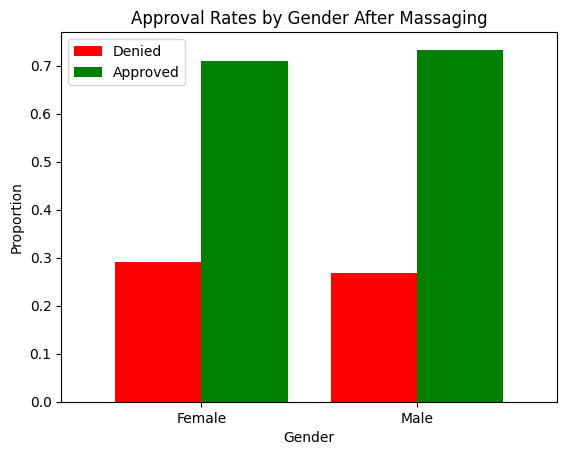

Approval Rates by Gender After Local Massaging:
Loan_Status         N         Y
Gender                         
Female       0.285714  0.714286
Male         0.267097  0.732903



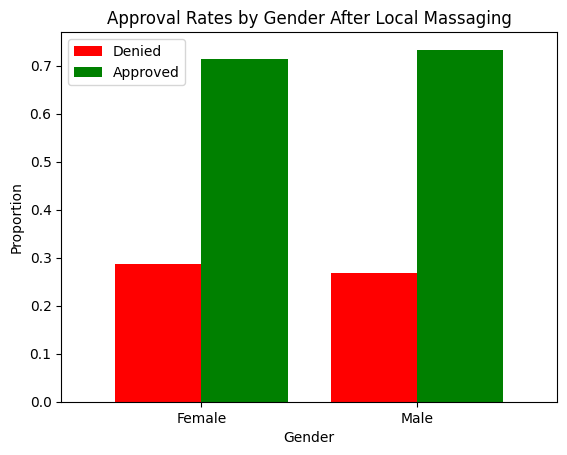

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('/content/credit_risk.csv')

# Assuming 'Loan_Status' and 'Gender' are columns in your dataset
# Initial visualization function
def plot_approval_rates_by_gender(df, title):
    approval_rates = df.groupby('Gender')['Loan_Status'].value_counts(normalize=True).unstack()
    print(f"{title}:\n{approval_rates}\n")
    # Create a side-by-side bar graph for 'Approved' and 'Denied'
    ax = approval_rates.plot(kind='bar', color=['red', 'green'], width=0.8)
    plt.title(title)
    plt.ylabel('Proportion')
    plt.xlabel('Gender')
    plt.xticks(rotation=0)
    plt.legend(['Denied', 'Approved'])
    plt.show()


# Initial approval rates visualization
plot_approval_rates_by_gender(data, 'Initial Approval Rates by Gender')

# Function to apply massaging
def apply_massaging(df, target_gender, target_status, adjustment):
    # Identify the subset of data to adjust
    subset = df[(df['Gender'] == target_gender) & (df['Loan_Status'] != target_status)]
    # Calculate the number of entries to adjust
    num_to_adjust = int(len(subset) * adjustment)
    # Change the loan status of a random sample of the subset
    indices_to_adjust = np.random.choice(subset.index, num_to_adjust, replace=False)
    df.loc[indices_to_adjust, 'Loan_Status'] = target_status
    return df

# Apply massaging to increase female approvals by 5%
massaged_data = apply_massaging(data.copy(), 'Female', 'Y', 0.05)
plot_approval_rates_by_gender(massaged_data, 'Approval Rates by Gender After Massaging')

def apply_local_massaging(df, condition, adjustment):
    # Subset based on the given condition
    subset = df[condition]
    # Further narrow down the subset to the specific group we want to adjust
    adjust_subset = subset[(subset['Gender'] == 'Female') & (subset['Loan_Status'] == 'N')]

    # Calculate the number of entries to adjust, ensuring it doesn't exceed available instances
    num_to_adjust = int(len(adjust_subset) * adjustment)
    num_to_adjust = min(num_to_adjust, len(adjust_subset))  # Ensure not to exceed the number of available entries

    # Change the loan status of a random sample of the subset, if any are available
    if num_to_adjust > 0:
        indices_to_adjust = np.random.choice(adjust_subset.index, num_to_adjust, replace=False)
        df.loc[indices_to_adjust, 'Loan_Status'] = 'Y'

    return df


# Example condition: Applicants with incomes below the median
median_income = data['ApplicantIncome'].median()
condition = data['ApplicantIncome'] < median_income

# Apply local massaging to increase approvals for low-income females by 10%
local_massaged_data = apply_local_massaging(data.copy(), condition, 0.1)
plot_approval_rates_by_gender(local_massaged_data, 'Approval Rates by Gender After Local Massaging')


Approval Rates by Gender k-NN Relabeling:
Loan_Status         N         Y
Gender                         
Female       0.285714  0.714286
Male         0.265806  0.734194



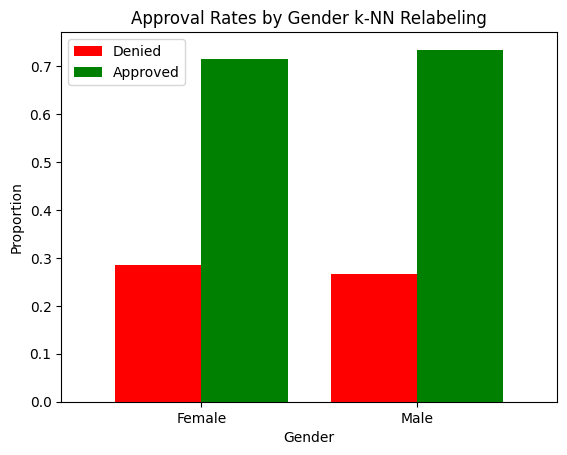

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Use KNeighborsClassifier for a more straightforward implementation that handles labeling directly
k_values = np.linspace(3, 15, num=5, dtype=int)  # Range of k values to test
best_k = 3
best_accuracy = 0

# Finding the best k by simple loop (more rigorous methods like cross-validation could be used)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracy = knn.score(X_test, y_test)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

# Using the best k found to train the final model
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train, y_train)
y_pred = knn_final.predict(X_test)

# Update the labels in the original dataframe based on the predictions
data.loc[X_test.index, 'Loan_Status'] = y_pred

def plot_approval_rates_by_gender(df, title):
    approval_rates = df.groupby('Gender')['Loan_Status'].value_counts(normalize=True).unstack()
    print(f"{title}:\n{approval_rates}\n")
    # Create a side-by-side bar graph for 'Approved' and 'Denied'
    ax = approval_rates.plot(kind='bar', color=['red', 'green'], width=0.8)
    plt.title(title)
    plt.ylabel('Proportion')
    plt.xlabel('Gender')
    plt.xticks(rotation=0)
    plt.legend(['Denied', 'Approved'])
    plt.show()


# Display initial and adjusted approval rates
plot_approval_rates_by_gender(data, 'Approval Rates by Gender k-NN Relabeling')


Method 2

Downsampling - will modify the class distributions by either increasing the minority class size or decreasing the majority class size

Approval Rates After Downsampling:
Loan_Status         N         Y
Gender                         
Female       0.285714  0.714286
Male         0.265806  0.734194



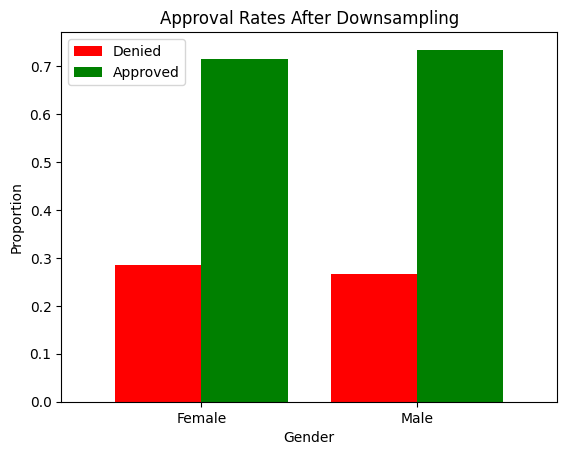

In [ ]:
from sklearn.utils import resample


# Splitting the data into majority and minority based on 'Loan_Status'
majority = data[data['Loan_Status'] == 'N']
minority = data[data['Loan_Status'] == 'Y']

# Downsampling the majority class if it has more samples than the minority
if len(majority) > len(minority):
    majority_downsampled = resample(majority,
                                    replace=False,    # sample without replacement
                                    n_samples=len(minority),  # match minority size
                                    random_state=123)  # reproducible results
    downsampled_data = pd.concat([majority_downsampled, minority])
else:
    downsampled_data = data  # If not possible to downsample, use the original data

# Plot the downsampling results
plot_approval_rates_by_gender(downsampled_data, 'Approval Rates After Downsampling')


Upsampling

Approval Rates After Upsampling:
Loan_Status         N         Y
Gender                         
Female       0.285714  0.714286
Male         0.265806  0.734194



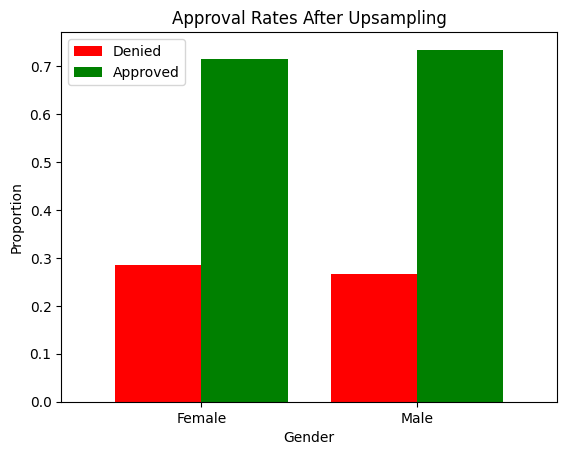

In [ ]:
from sklearn.utils import resample

# Upsampling the minority class if it has fewer samples than the majority
if len(minority) < len(majority):
    minority_upsampled = resample(minority,
                                  replace=True,   # sample with replacement
                                  n_samples=len(majority),  # to match majority size
                                  random_state=123)  # reproducible results
    upsampled_data = pd.concat([majority, minority_upsampled])
else:
    upsampled_data = data  # If not possible to upsample, use the original data

# Plot the upsampling results
plot_approval_rates_by_gender(upsampled_data, 'Approval Rates After Upsampling')


Method 3

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load the dataset
data = pd.read_csv('/content/credit_risk.csv')

# Extract features and labels
features = data[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']]
labels = data['Loan_Status']

# Handle missing values by imputation
imputer = SimpleImputer(strategy='mean')  # Imputing with the mean of each column
features_imputed = imputer.fit_transform(features)

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# Apply PCA to reduce dimensions while attempting to remove bias
pca = PCA(n_components=2)  # Reduce to two principal components for simplicity
features_pca = pca.fit_transform(features_scaled)

# Add transformed features back to a new dataframe
transformed_data = pd.DataFrame(features_pca, columns=['PC1', 'PC2'])
transformed_data['Loan_Status'] = labels
transformed_data['Gender'] = data['Gender']

def plot_approval_rates_by_gender(df, title):
    approval_rates = df.groupby('Gender')['Loan_Status'].value_counts(normalize=True).unstack()
    print(f"{title}:\n{approval_rates}\n")
    # Create a side-by-side bar graph for 'Approved' and 'Denied'
    ax = approval_rates.plot(kind='bar', color=['red', 'green'], width=0.8)
    plt.title(title)
    plt.ylabel('Proportion')
    plt.xlabel('Gender')
    plt.xticks(rotation=0)
    plt.legend(['Denied', 'Approved'])
    plt.show()


# Display approval rates after PCA transformation
plot_approval_rates_by_gender(transformed_data, 'Approval Rates by Gender After PCA')


FileNotFoundError: [Errno 2] No such file or directory: '/content/credit_risk.csv'